In [4]:
!pip install -U openmim
!mim install
!mim install "mmcv>=2.0.0"
!git clone -b main https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!git checkout master
print("DONE")

!pip install -v -e .
# '-v' means verbose, or more output
# '-e' means installing a project in editable mode,
# thus any local modifications made to the code will take effect without reinstallation.
%cd ../


ERROR: You must give at least one requirement to install (maybe you meant "pip install https://download.openmmlab.com/mmcv/dist/cu118/torch2.1.0/index.html"?)
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.1.0/index.html
fatal: destination path 'mmsegmentation' already exists and is not an empty directory.
/content/mmsegmentation
Branch 'master' set up to track remote branch 'master' from 'origin'.
Switched to a new branch 'master'
DONE
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Obtaining file:///content/mmsegmentation
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-zwbdywaf/mmsegmentation.egg-info
  writing manifest file '/tmp/pip-pip-egg-info-zwbdywaf/mmsegmentation.egg-info/SOURCES.txt'
  writing manifest file '/tmp/pip-pip-egg-info-zwbdywaf/mmsegmentation.egg-info/SOURCES.txt'
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.8/648.8 

In [ ]:
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob
from torchvision.datasets import VOCSegmentation


In [4]:
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask): # mask là 1 image RGB (H, W, 3)
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32) # tạo 1 object mask (H, W, 21)
        for label_index, label in enumerate(VOC_COLORMAP):
          segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float) # mask == label trả về matrix T/F (H, W, 3) check từng pixel theo chiều sâu channels.
                                                                                              # np.all sẽ kiểm tra nếu pixel nào có channel cùng màu với VOC_COLORMAP thì trả về True, ta dc 1 matrix True/False (H, W).
                                                                                              # astype() convert matrix [True False] về kiểu float [1. 0.]

        return segmentation_mask #0, 1, 2, 3, ..., 20 (H, W, C)

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
          transformed = self.transform(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]
        return image, mask.argmax(dim=2).squeeze() #torch.tensor argmax()-> (H, W, 1) -> (H, W) #numpy

In [5]:
trainsize = 256

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
    A.Cutout(num_holes=5, max_h_size=25, max_w_size=25, fill_value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_trainsform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [6]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc
Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


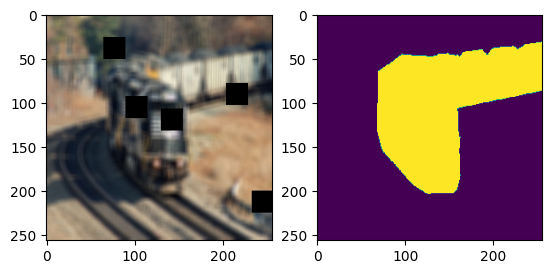

In [7]:
train_dataset = PascalVOCSearchDataset(image_set="train", download=True, transform=train_transform)
test_dataset = PascalVOCSearchDataset(image_set="val", download=True, transform=test_trainsform)

image, mask = train_dataset.__getitem__(10)
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()


In [8]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

In [10]:
!python mmsegmentation/tools/model_converters/mit2mmseg.py mit_b0.pth mit_b0_mmseg.pth
!python mmsegmentation/tools/model_converters/mit2mmseg.py mit_b1.pth mit_b1_mmseg.pth
!python mmsegmentation/tools/model_converters/mit2mmseg.py mit_b2.pth mit_b2_mmseg.pth
!python mmsegmentation/tools/model_converters/mit2mmseg.py mit_b3.pth mit_b3_mmseg.pth
!python mmsegmentation/tools/model_converters/mit2mmseg.py mit_b4.pth mit_b4_mmseg.pth
# !python mmsegmentation/tools/model_converters/mit2mmseg.py mit_b5.pth mit_b5_mmseg.pth

12/11 18:14:03 - mmengine - INFO - Loads checkpoint by local backend from path: mit_b0.pth
12/11 18:14:08 - mmengine - INFO - Loads checkpoint by local backend from path: mit_b1.pth
12/11 18:14:13 - mmengine - INFO - Loads checkpoint by local backend from path: mit_b2.pth
12/11 18:14:19 - mmengine - INFO - Loads checkpoint by local backend from path: mit_b3.pth
12/11 18:14:24 - mmengine - INFO - Loads checkpoint by local backend from path: mit_b4.pth


In [12]:
!pip install ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 764.4 kB/s eta 0:00:00


In [13]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 24
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model settings
norm_cfg = dict(type='BN', requires_grad=True)
model_cfg = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 8, 27, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg = dict(type="Pretrained", checkpoint="mit_b4_mmseg.pth")),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=21,
        norm_cfg=norm_cfg,
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    # model training and testing settings
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))

import mmcv
from mmseg.models import build_segmentor
model = build_segmentor(model_cfg).to(device)
model.init_weights()

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
n_eps = 30

#meter
train_loss_meter = AverageMeter()
intersection_meter = AverageMeter()
union_meter = AverageMeter()
target_meter = AverageMeter()

num_workers = 2


/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


12/11 18:16:20 - mmengine - INFO - load model from: mit_b4_mmseg.pth
12/11 18:16:20 - mmengine - INFO - Loads checkpoint by local backend from path: mit_b4_mmseg.pth
12/11 18:16:20 - mmengine - INFO - 
backbone.layers.0.0.projection.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from mit_b4_mmseg.pth 
 
12/11 18:16:20 - mmengine - INFO - 
backbone.layers.0.0.projection.bias - torch.Size([64]): 
PretrainedInit: load from mit_b4_mmseg.pth 
 
12/11 18:16:20 - mmengine - INFO - 
backbone.layers.0.0.norm.weight - torch.Size([64]): 
PretrainedInit: load from mit_b4_mmseg.pth 
 
12/11 18:16:20 - mmengine - INFO - 
backbone.layers.0.0.norm.bias - torch.Size([64]): 
PretrainedInit: load from mit_b4_mmseg.pth 
 
12/11 18:16:20 - mmengine - INFO - 
backbone.layers.0.1.0.norm1.weight - torch.Size([64]): 
PretrainedInit: load from mit_b4_mmseg.pth 
 
12/11 18:16:20 - mmengine - INFO - 
backbone.layers.0.1.0.norm1.bias - torch.Size([64]): 
PretrainedInit: load from mit_b4_mmseg.pth 
 
12/

In [15]:
for ep in range(1, 1+n_eps):
    train_loss_meter.reset()
    intersection_meter.reset()
    union_meter.reset()
    target_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model.forward_dummy(x) #(B, C, H, W)
        loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        #save metrics
        with torch.no_grad():
            train_loss_meter.update(loss.item())
            y_hat_mask = y_hat.argmax(dim=1).squeeze(1) # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 21)
            intersection_meter.update(intersection)
            union_meter.update(union)
            target_meter.update(target)

    #compute iou, dice
    with torch.no_grad():
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10) #vector 21D
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D

        mIoU = torch.mean(iou_class) #mean vector 21D
        mDice = torch.mean(dice_class) #mean vector 21D

    print("EP {}, current_lr = {} , train loss = {} IoU = {}, dice = {}".format(ep, scheduler.get_last_lr(), train_loss_meter.avg, mIoU, mDice))
    scheduler.step()

    if ep >= 25:
        torch.save(model.state_dict(), "modelSegFormer_ep_{}.pth".format(ep))

  0%|          | 0/61 [00:18<?, ?it/s]


AttributeError: ignored

In [ ]:
# evaluation
model.eval()
test_intersection_meter = AverageMeter()
test_union_meter = AverageMeter()
test_target_meter = AverageMeter()
with torch.no_grad():
  for batch_id, (x, y) in enumerate(tqdm(testloader), start = 1):
    n = x.shape[0]
    x = x.to(device).float()
    y = y.to(device).long()
    y_hat = model.forward_dummy(x)
    y_hat_mask = y_hat.argmax(dim = 1).squeeze()

    intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 21)
    intersection_meter.update(intersection)
    union_meter.update(union)
    target_meter.update(target)

  iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)  # vector 21D
  dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D

  mIoU = torch.mean(iou_class)  #mean vector 21D
  mDice = torch.mean(dice_class)  #mean vector 21D
print("TEST: iou = {}, dice = {}".format( mIoU, mDice))



In [ ]:
import random
# predict
id = random.randint(0, train_dataset.__len__())

with torch.no_grad():
  model.eval()
  x, y = test_dataset.__getitem__(id)
  y_predict = model.forward_dummy(x.unsqueeze(0).to(device)).argmax(dim=1).squeeze()
  intersection, union, target = intersectionAndUnionGPU(y_predict.float(), y.float(), 21)
  iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)  # vector 21D
  dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D

  mIoU = torch.mean(iou_class)  #mean vector 21D
  mDice = torch.mean(dice_class)  #mean vector 21D
  print("IoU = {}; Dice = {}".format(mIoU, mDice))
  # print(np.unique(y_predict))
  # print(y_predict.shape)
  y_predict = y_predict.cpu().numpy()
  color_mask_predict = np.zeros((*y_predict.shape, 3))
  for i, color in enumerate(VOC_COLORMAP):
    color_mask_predict[y_predict==i] = np.array(color)
  color_mask = np.zeros((*y_predict.shape, 3))
  for i, color in enumerate(VOC_COLORMAP):
    color_mask[y==i] = np.array(color)
  plt.subplot(1,3,1)
  plt.imshow(unorm(x).permute(1, 2, 0))
  plt.subplot(1,3,2)
  plt.imshow(color_mask)
  plt.subplot(1,3,3)
  plt.imshow(color_mask_predict)
  plt.show()